In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as skl
import math as mt
import seaborn as sn
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
currentFile = open("high_diamond_ranked_10min.csv")
dfInitial = pd.read_csv(currentFile)
#dfInitial
len(dfInitial.columns)

40

In [3]:
#Eliminer les outliers (peu/pas de monstres jungles tués, bcp de wards posées, peu de sbires tués)
#on s'en branle du gameID
#blueDeath et redDeath un peu useless, excepté pour quelques execute (on peut le vérifier)
#totalexp et avglevel c'est un peu la même
#se contenter de bluegoldiff et blueexpdiff
#totalminionkilled et minionperminutes
#same pour goldperminute et totalgold
#elitemonsters c'est juste la somme des drake et herald (osef)
#firstblood redondant (sauf dans les cas à 0 kills mais wsh c'est rare)
#TargetValue = blueWin

#To drop :
#gameId
#redAvgLevel, blueAvgLevel, redTotalExperience, blueTotalExperience,
#redTotalGold, blueTotalGold, redGoldPerMin, blueGoldPerMin,
#redCSPerMin, blueCSPerMin,
#redExperienceDiff, redGoldDiff, redFirstBlood

# Preprocessing

## Sélection de features

### Suppression des colonnes redondantes
De nombreuses features sont redondantes entre elles, on va donc les supprimer afin de simplifier notre dataset sans pour autant perdre de l'information.

**Les informations équivalentes sont les suivantes:**
* Le nombre total de sbires tués et le nombre moyen de sbires tués par chaque équipe.
* Le total d’or de chaque équipe, et le nombre d’or par minute.
* Le nombre total de monstres élite tués est en fait la somme des dragons et hérauts tués.
* Les différences d’or et d’expérience de l'équipe bleu, et celles de l'équipe rouges, peuvent être obtenues grâce au total d'or des 2 équipes
* Le nombre total de sbires tués et le nombre de sbires tués par minutes par chaque équipe.
* Les morts de chaque équipe sont intimement liés aux kills de l’équipe adverse, bien que la correspondance ne soit pas parfaite dans certaines parties.
* Le booléen “first-blood”, indiquant si l'équipe est la première a avoir fait un kill, est présent pour les 2 équipes.

**Autre:**
* Le gameID permet d'identifier la partie, ce qui n’est pas utile à notre analyse

Lorsque chaque équipe possède une feature réprésentant la même information, on privilégiera celle de l'équipe bleue (ex. pour la différence d'or on supprimera redGoldDiff)

In [4]:
toDrop = ["gameId", "redAvgLevel", "blueAvgLevel", "redTotalExperience", "blueTotalExperience",
          "redTotalGold", "blueTotalGold", "redGoldPerMin", "blueGoldPerMin", "redCSPerMin","blueCSPerMin",
          "redExperienceDiff", "redGoldDiff", "redFirstBlood", "redEliteMonsters", "blueEliteMonsters"]
dfSimplified = dfInitial.drop(toDrop, axis = 1)
#dfSimplified
len(dfSimplified.columns)

24

### Colonnes redDeaths et redKills
Les morts et les éliminiations d'une équipe sont fortement liées aux éliminations et aux morts de l'autre équipe, mais il est possible que la mort d'un joueur ne compte pas comme une élimination pour l'équipe adverse, on parle alors d'exécution. Nous allons nous intéresser au nombre de parties où ces données diffèrent afin de déterminer s'il est pertinent de supprimer ces features, ou si cela nous ferait perdre trop d'information

In [5]:
dfExecute = dfSimplified[(dfSimplified["redDeaths"] != dfSimplified["blueKills"]) | (dfSimplified["redKills"] != dfSimplified["blueDeaths"])]
len(dfExecute)

0

On remarque que notre dataset ne contient pas de parties dans laquelle un joueur a été exécuté, nous pouvons donc supprimer ces features sans perdre de l'information

In [6]:
dfSimplified = dfSimplified.drop(["redDeaths", "redKills"], axis = 1)
#dfSimplified
len(dfSimplified.columns)

22

### Héraut de la faille
On sait qu'il ne peut y avoir qu'un seul héraut de la faille dans les 10 premières minutes, on peut donc fusionner les 2 colonnes blueHeralds et redHeralds, on aurait alors 3 valeurs possible : 1, 0 et -1 correspondant à blue, red et none

In [7]:
colHeralds = dfSimplified[["blueHeralds", "redHeralds"]]
colHeralds.loc[:, 'heralds'] = -1
def convertHeraldStats(dataframe):
    for index, current in colHeralds.iterrows():
        if current['blueHeralds'] == 1:
            current['heralds'] = 1
        elif current['redHeralds'] == 1:
            current['heralds'] = 0
    return dataframe["heralds"]

dfSimplified = dfSimplified.drop(["redHeralds", "blueHeralds"], axis = 1);
dfSimplified["heralds"] = convertHeraldStats(colHeralds)
len(dfSimplified.columns)

<ipython-input-7-3abcf0b2b93c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colHeralds.loc[:, 'heralds'] = -1


21

In [8]:
dfSimplified

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueTowersDestroyed,blueTotalMinionsKilled,...,blueGoldDiff,blueExperienceDiff,redWardsPlaced,redWardsDestroyed,redAssists,redDragons,redTowersDestroyed,redTotalMinionsKilled,redTotalJungleMinionsKilled,heralds
0,0,28,2,1,9,6,11,0,0,195,...,643,-8,15,6,8,0,0,197,55,-1
1,0,12,1,0,5,5,5,0,0,174,...,-2908,-1173,12,1,2,1,1,240,52,0
2,0,15,0,0,7,11,4,1,0,186,...,-1172,-1033,15,3,14,0,0,203,28,-1
3,0,43,1,0,4,5,5,0,0,201,...,-1321,-7,15,2,10,0,0,235,47,1
4,0,75,4,0,6,6,6,0,0,210,...,-1004,230,17,2,7,1,0,225,67,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,4,5,1,0,211,...,2519,2469,46,3,7,0,0,229,34,-1
9875,1,54,0,0,6,4,8,1,0,233,...,782,888,12,21,3,0,0,206,56,-1
9876,0,23,1,0,6,7,5,0,0,210,...,-2416,-1877,14,0,11,1,0,261,60,-1
9877,0,14,4,1,2,3,3,1,0,224,...,-839,-1085,66,4,1,0,0,247,40,-1


## Feature mapping

# Dédoubler les données

## Objectif
Doubler nos données permettrait d'augmenter virtuellement la taille de notre dataset, et donc d'avoir un modèle mieux entraîné et globalement plus fiable.
## Problème
Le jeu est fait de sorte que chaque équipe ai les même chances de gagner, cependant un aspect important du jeu n'est pas symétrique : les monstres élites.
Les monstres élites (dragons et hérauts de la faille) offrent de nombreux avantages aux joueurs (or, expérience, statistiques, prise de tour), mais dû à la forme de la carte, chaque équipe est théoriquement avantagée sur la prise d'un type de monstre élites.

![L'image Lol_Map.png n'a pas pu être chargé](images/LoL_Map.png) 
## Principe
Nous allons donc comparer la prévalence des différents monstres élites dans les parties gagnées, ainsi que la proportion de parties où les différents objectifs ont été pris par chaque équipe. Si les monstres élites influent peu sur le taux de victoire, ou si chaque équipe a en réalité le même nombre de monstre élite en moyenne, alors nous pourrons considérer doubler les données.

### Hérauts de la faille

Hérauts bleus : 1857
Hérauts rouges : 1581
Un héraut est fait par l'équipe bleue dans 18.8 % des parties
Un héraut est fait par l'équipe rouge dans 16.0 % des parties


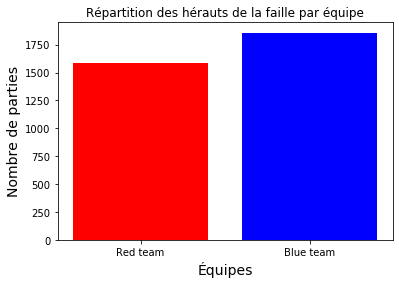

In [9]:
def HeraldRepartition(dataframe):
    cols = dataframe[dataframe['heralds'] > -1]
    blue = 0
    red = 0
    amount = []

    for index, current in cols.iterrows():
        if current['heralds'] == 1:
            blue = blue + 1
        elif current['heralds'] == 0:
            red = red + 1
        amount.append(1)
        
    print('Hérauts bleus :', blue)
    print('Hérauts rouges :', red)
    print('Un héraut est fait par l\'équipe bleue dans', round(100*blue/len(dataframe), 1), '% des parties')
    print('Un héraut est fait par l\'équipe rouge dans', round(100*red/len(dataframe), 1), '% des parties')
    plt.title("Répartition des hérauts de la faille par équipe")
    g = sn.barplot(x="heralds",y=amount,data=cols)
    g.set(xticklabels=["Red team", "Blue team"])
    plt.xlabel("Équipes", size=14)
    plt.ylabel("Nombre de parties", size=14)
    plt.bar(['red', 'blue'], height = [red, blue], color = ['red', 'blue'])
    plt.show()
HeraldRepartition(dfSimplified)

On voit effectivement que l'équipe bleu est avantagée sur la prise des hérauts, la probabilité que l'équipe bleue fasse le héraut est plus élevée de presque 3%. 

### Dragons